# Data Cleaning and Pre-Processing

### Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Dataset of Skin Images From Kaggle

In [2]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d farjanakabirsamanta/skin-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/farjanakabirsamanta/skin-cancer-dataset
License(s): other
100% 2.57G/2.58G [00:40<00:00, 90.7MB/s]
100% 2.58G/2.58G [00:40<00:00, 68.8MB/s]


In [4]:
# Extract skin images from our zip file
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Import Libraries

In [5]:
import os
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

### Separating Images Based on Skin Cancer Types

In [7]:
# Display first 5 lines of csv file
meta_data = pd.read_csv('/content/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
print("Unique Cancer Types Represented in the Data")
print(meta_data.dx.unique(), "\n")

# Handle Categorical Data
encoder = LabelEncoder()
meta_data['dx_label'] = encoder.fit_transform(meta_data['dx'])

# Display labels and interger encoding
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer Types Represented in the Data
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [10]:
img_path = "/content/Skin Cancer/Skin Cancer/"
files = os.listdir(img_path)

image_files = [file for file in files if file.endswith('.jpg')]

# Count number of images in folder
num_images = len(image_files)
print(f"Number of images in the folder: {num_images}")

Number of images in the folder: 10015


In [11]:
training_dir = "/content/Training_Set"
os.makedirs(training_dir, exist_ok=True)

In [12]:
# Group images by cancer type
cancer_types = meta_data['dx'].unique()

# Copy images to seperated directories based on cancer type
for cancer_type in cancer_types:
  # Create directory for each cancer type within training directory
    cancer_type_dir = os.path.join(training_dir, cancer_type)
    os.makedirs(cancer_type_dir, exist_ok=True)

    # Filter images corresponding to the current cancer type
    images_of_cancer_type = meta_data[meta_data['dx'] == cancer_type]['image_id'].values

    # Copy images to the corresponding directory
    for image_name in images_of_cancer_type:
        source_path = os.path.join(img_path, image_name + '.jpg')
        destination_path = os.path.join(cancer_type_dir, image_name + '.jpg')
        shutil.copy(source_path, destination_path)

In [13]:
# Get list of subdirectories within the train directory
subdirs = [subdir for subdir in os.listdir(training_dir) if os.path.isdir(os.path.join(training_dir, subdir))]

# Print the subdirectories and count of images in each subdirectory
for subdir in subdirs:
    subdir_path = os.path.join(training_dir, subdir)
    num_images = len(os.listdir(subdir_path))
    print(f"Subdirectory: {subdir}, Number of Images: {num_images}")

Subdirectory: bkl, Number of Images: 1099
Subdirectory: akiec, Number of Images: 327
Subdirectory: vasc, Number of Images: 142
Subdirectory: mel, Number of Images: 1113
Subdirectory: df, Number of Images: 115
Subdirectory: nv, Number of Images: 6705
Subdirectory: bcc, Number of Images: 514


### Define Paths for our Skin Images

In [14]:
dirpath = os.getcwd()
PATH = os.path.join(dirpath, 'Training_Set')
PATH_ak = os.path.join(PATH, 'akiec')
PATH_bcc = os.path.join(PATH, 'bcc')
PATH_derm = os.path.join(PATH, 'df')
PATH_mel = os.path.join(PATH, 'mel')
PATH_nev = os.path.join(PATH, 'nv')
PATH_bkl = os.path.join(PATH, 'bkl')
PATH_vl = os.path.join(PATH, 'vasc')
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'benign keratosis', 'vascular lesion']

### Divide Paths for Images in Each Category


In [15]:
files_ak = os.listdir(PATH_ak)
files_bcc = os.listdir(PATH_bcc)
files_derm = os.listdir(PATH_derm)
files_mel = os.listdir(PATH_mel)
files_nev = os.listdir(PATH_nev)
files_bkl = os.listdir(PATH_bkl)
files_vl = os.listdir(PATH_vl)
print(len(files_ak), len(files_bcc), len(files_derm), len(files_mel), len(files_nev), len(files_bkl), len(files_vl))

paths_ak = [os.path.join(PATH_ak, file) for file in files_ak]
paths_bcc = [os.path.join(PATH_bcc, file) for file in files_bcc]
paths_derm = [os.path.join(PATH_derm, file) for file in files_derm]
paths_mel = [os.path.join(PATH_mel, file) for file in files_mel]
paths_nev = [os.path.join(PATH_nev, file) for file in files_nev]
paths_bkl = [os.path.join(PATH_bkl, file) for file in files_bkl]
paths_val = [os.path.join(PATH_vl, file) for file in files_vl]

# Number of paths per skin cancer category
paths_all = np.concatenate([paths_ak, paths_bcc, paths_derm, paths_mel, paths_nev, paths_bkl, paths_val])

327 514 115 1113 6705 1099 142


### Crop our Images and Define New Paths

In [16]:
# Set a target size to crop our images at
target_size =  (256, 256)

# Define function to center crop our images
def crop_center_opencv(image, size):
  height, width = image.shape[:2]
  top = (height - size[1]) // 2
  bottom = top + size[1]
  left = (width - size[0]) // 2
  right = left + size[0]
  return image[top:bottom, left:right]

category_paths = [PATH_ak, PATH_bcc, PATH_derm,  PATH_mel, PATH_nev, PATH_bkl, PATH_vl]

# Create directory folder to store our cropped images
cropped_dir = os.path.join(dirpath, 'Cropped_Images')
os.makedirs(cropped_dir, exist_ok=True)

# Nested for loops to resize and crop our images for processing
for i, category_path in enumerate(category_paths):
  category_name = class_names[i]
  save_dir = os.path.join(cropped_dir, category_name)
  os.makedirs(save_dir, exist_ok=True)

  files = os.listdir(category_path)

  for file in files:
    image_path = os.path.join(category_path, file)
    image = cv2.imread(image_path)

    height, width = image.shape[:2]
    if height < width:
      new_height = target_size[1]
      new_width = int(width * (new_height / height))
    else:
      new_width = target_size[0]
      new_height = int(height * (new_width / width))

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    cropped_image = crop_center_opencv(resized_image, target_size)

    save_path = os.path.join(save_dir, file)
    cv2.imwrite(save_path, cropped_image)

print("All images have been cropped and saved")

# Create paths for our cropped images
cropped_PATH = os.path.join(dirpath, 'Cropped_Images')
cropped_ak = os.path.join(cropped_PATH, 'actinic keratosis')
cropped_bcc = os.path.join(cropped_PATH, 'basal cell carcinoma')
cropped_derm = os.path.join(cropped_PATH, 'dermatofibroma')
cropped_mel = os.path.join(cropped_PATH, 'melanoma')
cropped_nev = os.path.join(cropped_PATH, 'melanocytic nevi')
cropped_bkl = os.path.join(cropped_PATH, 'benign keratosis')
cropped_vl = os.path.join(cropped_PATH, 'vascular lesion')

cropped_files_ak = os.listdir(cropped_ak)
cropped_files_bcc = os.listdir(cropped_bcc)
cropped_files_derm = os.listdir(cropped_derm)
cropped_files_mel = os.listdir(cropped_mel)
cropped_files_nev = os.listdir(cropped_nev)
cropped_files_pbk = os.listdir(cropped_bkl)
cropped_files_vl = os.listdir(cropped_vl)

cropped_paths_ak = [os.path.join(cropped_ak, file) for file in cropped_files_ak]
cropped_paths_bcc = [os.path.join(cropped_bcc, file) for file in cropped_files_bcc]
cropped_paths_derm = [os.path.join(cropped_derm, file) for file in cropped_files_derm]
cropped_paths_mel = [os.path.join(cropped_mel, file) for file in cropped_files_mel]
cropped_paths_nev = [os.path.join(cropped_nev, file) for file in cropped_files_nev]
cropped_paths_bkl = [os.path.join(cropped_bkl, file) for file in cropped_files_pbk]
cropped_paths_val = [os.path.join(cropped_vl, file) for file in cropped_files_vl]

df_ak = pd.DataFrame({'image': cropped_paths_ak, 'label': class_names[0]})
df_bcc = pd.DataFrame({'image': cropped_paths_bcc, 'label': class_names[1]})
df_derm = pd.DataFrame({'image': cropped_paths_derm, 'label': class_names[2]})
df_mel = pd.DataFrame({'image': cropped_paths_mel, 'label': class_names[3]})
df_nev = pd.DataFrame({'image': cropped_paths_nev, 'label': class_names[4]})
df_bkl = pd.DataFrame({'image': cropped_paths_bkl, 'label': class_names[5]})
df_vl = pd.DataFrame({'image': cropped_paths_val, 'label': class_names[6]})

# DataFrame of image paths and their label to train
train_data = pd.concat([df_ak, df_bcc, df_derm, df_mel, df_nev, df_bkl, df_vl])

All images have been cropped and saved


### Display The Number of Images per Category

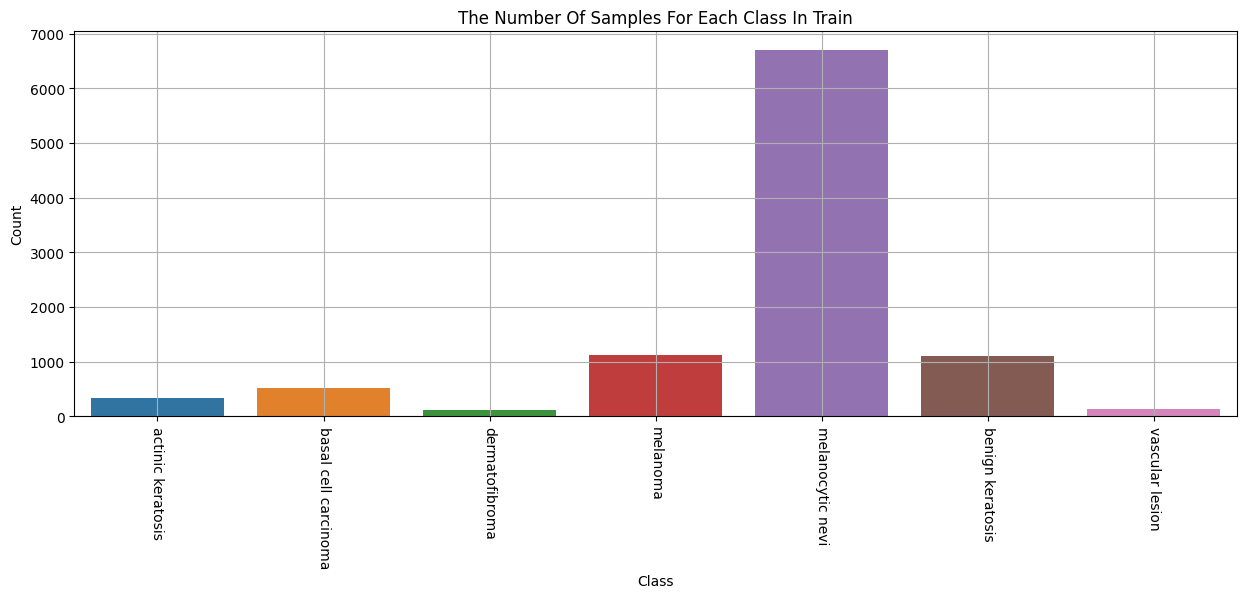

In [17]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=train_data.label, hue = train_data.label, legend = False)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title("The Number Of Samples For Each Class In Train")
plt.grid(True)
plt.xticks(rotation=-90)
plt.show()

#### Display Random Defect Image From Each Category

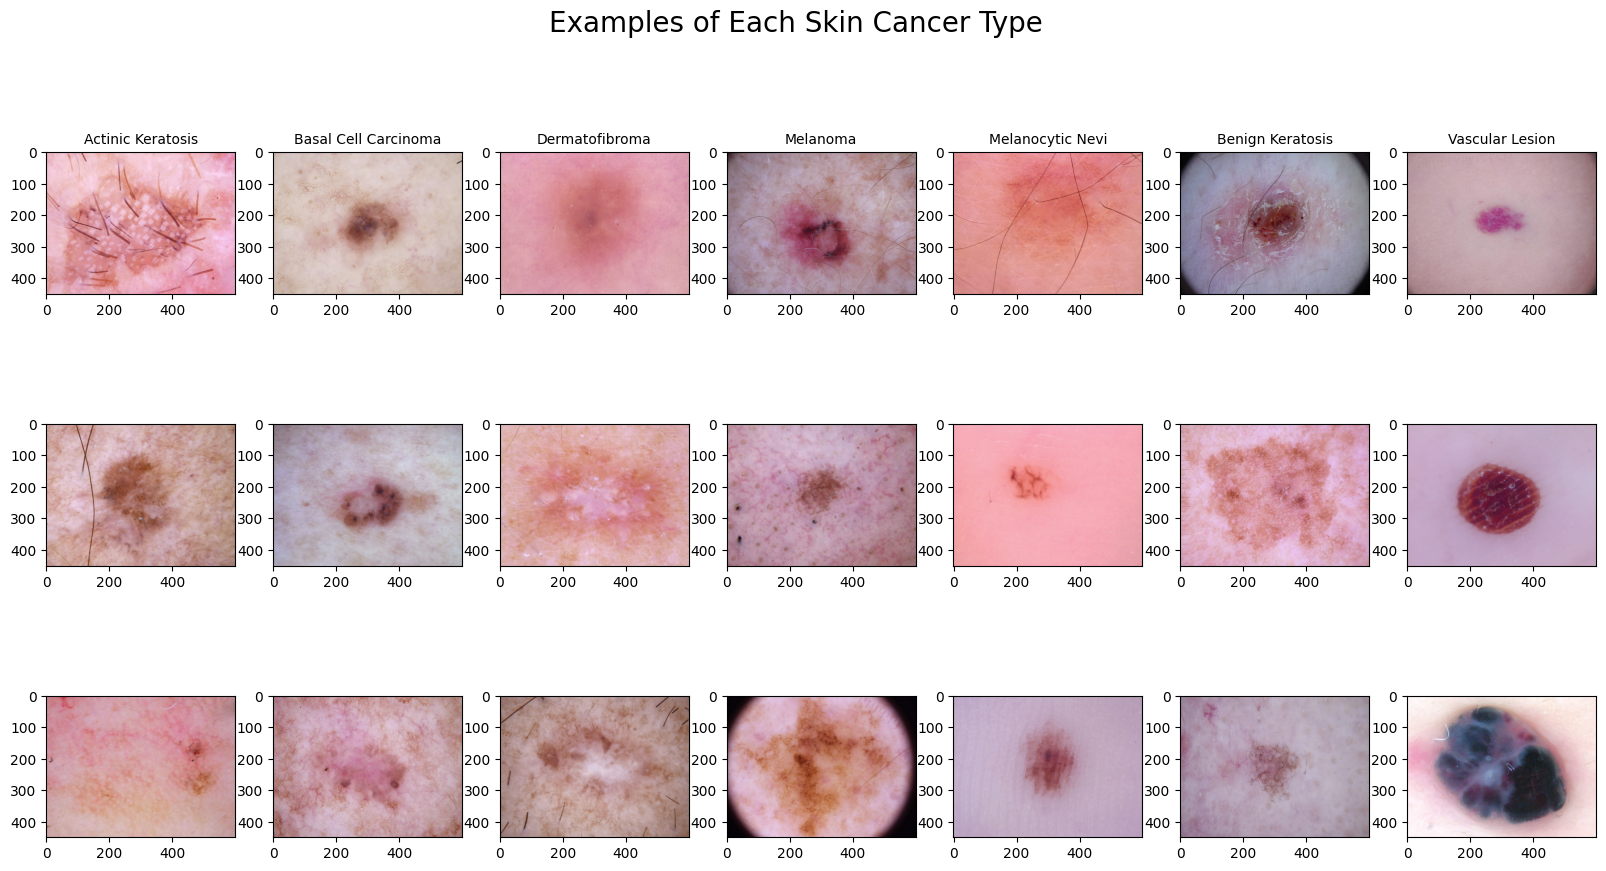

In [19]:

# Get 3 random images from each category to display
im_ak = [Image.open(os.path.join(PATH_ak, files_ak[np.random.randint(0, len(files_ak))])).convert('RGB'),
        Image.open(os.path.join(PATH_ak, files_ak[np.random.randint(0, len(files_ak))])).convert('RGB'),
        Image.open(os.path.join(PATH_ak, files_ak[np.random.randint(0, len(files_ak))])).convert('RGB')]
im_bcc = [Image.open(os.path.join(PATH_bcc, files_bcc[np.random.randint(0, len(files_bcc))])).convert('RGB'),
          Image.open(os.path.join(PATH_bcc, files_bcc[np.random.randint(0, len(files_bcc))])).convert('RGB'),
          Image.open(os.path.join(PATH_bcc, files_bcc[np.random.randint(0, len(files_bcc))])).convert('RGB')]
im_derm = [Image.open(os.path.join(PATH_derm, files_derm[np.random.randint(0, len(files_derm))])).convert('RGB'),
          Image.open(os.path.join(PATH_derm, files_derm[np.random.randint(0, len(files_derm))])).convert('RGB'),
           Image.open(os.path.join(PATH_derm, files_derm[np.random.randint(0, len(files_derm))])).convert('RGB')]
im_mel = [Image.open(os.path.join(PATH_mel, files_mel[np.random.randint(0, len(files_mel))])).convert('RGB'),
          Image.open(os.path.join(PATH_mel, files_mel[np.random.randint(0, len(files_mel))])).convert('RGB'),
          Image.open(os.path.join(PATH_mel, files_mel[np.random.randint(0, len(files_mel))])).convert('RGB')]
im_nev = [Image.open(os.path.join(PATH_nev, files_nev[np.random.randint(0, len(files_nev))])).convert('RGB'),
          Image.open(os.path.join(PATH_nev, files_nev[np.random.randint(0, len(files_nev))])).convert('RGB'),
          Image.open(os.path.join(PATH_nev, files_nev[np.random.randint(0, len(files_nev))])).convert('RGB')]
im_bkl = [Image.open(os.path.join(PATH_bkl, files_bkl[np.random.randint(0, len(files_bkl))])).convert('RGB'),
          Image.open(os.path.join(PATH_bkl, files_bkl[np.random.randint(0, len(files_bkl))])).convert('RGB'),
          Image.open(os.path.join(PATH_bkl, files_bkl[np.random.randint(0, len(files_bkl))])).convert('RGB')]
im_vl = [Image.open(os.path.join(PATH_vl, files_vl[np.random.randint(0, len(files_vl))])).convert('RGB'),
         Image.open(os.path.join(PATH_vl, files_vl[np.random.randint(0, len(files_vl))])).convert('RGB'),
         Image.open(os.path.join(PATH_vl, files_vl[np.random.randint(0, len(files_vl))])).convert('RGB')]


# Display those 3 random images
fig, axs = plt.subplots(len(im_ak),7)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle("Examples of Each Skin Cancer Type", fontsize=20)
for i, im in enumerate(im_ak):
  axs[i][0].imshow(im, vmin = 0, vmax = 225)
  axs[0][0].set_title('Actinic Keratosis', fontsize=10)
for i, im in enumerate(im_bcc):
  axs[i][1].imshow(im, vmin = 0, vmax=225)
  axs[0][1].set_title('Basal Cell Carcinoma', fontsize=10)
for i, im in enumerate(im_derm):
  axs[i][2].imshow(im, vmin = 0, vmax=225)
  axs[0][2].set_title('Dermatofibroma', fontsize=10)
for i, im in enumerate(im_mel):
  axs[i][3].imshow(im, vmin = 0, vmax=225)
  axs[0][3].set_title('Melanoma', fontsize=10)
for i, im in enumerate(im_nev):
  axs[i][4].imshow(im, vmin = 0, vmax=225)
  axs[0][4].set_title('Melanocytic Nevi', fontsize=10)
for i, im in enumerate(im_bkl):
  axs[i][5].imshow(im, vmin = 0, vmax=225)
  axs[0][5].set_title('Benign Keratosis', fontsize=10)
for i, im in enumerate(im_vl):
  axs[i][6].imshow(im, vmin = 0, vmax=225)
  axs[0][6].set_title('Vascular Lesion', fontsize=10)


## Transfer Files to Google Drive

In [ ]:
# Transfer all files to our google drive folder
!sudo cp -v -r "/content/Cropped_Images/" "/content/drive/MyDrive/Skin_Lesion_Project/Data Cleaning and Pre-Processing"
!sudo cp -v -r "/content/Training_Set" "/content/drive/MyDrive/Skin_Lesion_Project/Data Cleaning and Pre-Processing"
!sudo cp -v -r "/content/HAM10000_metadata.csv" "/content/drive/MyDrive/Skin_Lesion_Project/Data Cleaning and Pre-Processing"